## Tutorial of TiDoFM: for single signal

In [38]:
import numpy as np
from antenna_pattern_class import *
import antenna_pattern_class

from snr_class import *
import snr_class

from fm_class import *
import fm_class

### 1, calculate the antenna pattern function
#### Input: 
* source parameters:{ra: right ascension, dec: declination, pol: polarization}
* detector parameters: {Det: detector name}
> **Note:** The default detector is assumed to be located at Virgo site with sensitivity of ET-D configuration

In [7]:
source_params = {'ra': 0.5, 'dec': 0.3, 'pol': 0.0}
detector_params = {'Det': 'ET_1_10km_cryo'}
GPST = 1234567890.0

ap = AntennaPattern(source_params, detector_params, GPST)
Fp, Fc = ap.AP()
print('Fplus:', Fp, 'Fcross:', Fc)

Fplus: [-0.14244913] Fcross: [-0.08394634]


### 2, Inject time domain signals
> **Note:** You can simulate signals using other tools. 
The following are some test signals generated to demonstrate how to calculate the SNR.

In [10]:
signal_duration = 2030
simulated_signal = list(snr.generate_signal(signal_duration))
hp_hc = {'hp':simulated_signal, 'hc': simulated_signal}

In [11]:
source_params = {'Mtot': 2.8*SNRCalculator.MSUN, 'eta': 0.25, 'ra': 0.27, 'dec': 0.31, 'pol': 0.0, 'iota': 0.78}
detector_params = {'Det': 'ET_1_10km_cryo'}
GPST = 1234567890.0

> **Note:** We first divide the signals into multiple time segments, each with a defined length of segment_size.
The final output is (1)a time series, with the time of merger set at time 0 and intervals defined by segment_size; 
(2) the signal-to-noise ratio corresponding to the end point of each time segment will be obtained.

### 3, calculate the SNR

In [28]:
snr = SNRCalculator(sample_rate = 4096, segment_size = 100, GPST = GPST, source_params = source_params, detector_params = detector_params)
# Calculate the SNR
snr_info = snr.calculate_snr(signal = hp_hc)
# Print the results
import pandas as pd
df = pd.DataFrame({"time": snr_info['time_to_coalescence'], "SNR": snr_info['snrs']})
print(df)

      time       SNR
0  -1930.0  0.008602
1  -1830.0  0.011512
2  -1730.0  0.014202
3  -1630.0  0.016157
4  -1530.0  0.018774
5  -1430.0  0.020736
6  -1330.0  0.023031
7  -1230.0  0.024878
8  -1130.0  0.027249
9  -1030.0  0.029712
10  -930.0  0.031605
11  -830.0  0.033824
12  -730.0  0.036383
13  -630.0  0.038868
14  -530.0  0.041651
15  -430.0  0.044945
16  -330.0  0.048655
17  -230.0  0.055297
18  -130.0  0.068901
19   -30.0  0.133655
20     0.0  2.556421


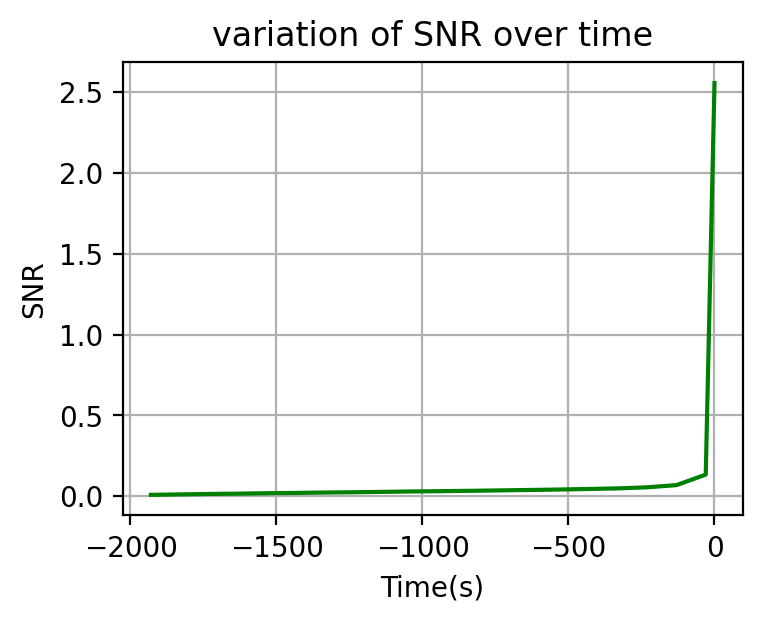

In [29]:
import matplotlib.pyplot as plot
plot.figure(figsize = (4,3), dpi = 200)
plot.plot(snr_info['time_to_coalescence'], snr_info['snrs'], 'g')
plot.xlabel('Time(s)', fontsize = 10)
plot.ylabel('SNR', fontsize = 10)
plot.title('variation of SNR over time')
plot.grid()

### 4, calculate the Fisher Matrix
#### Input: 
* delta_param: Fisher Matrix elements, and their corresponding increment of the element. 
* hp_sim_signal, hc_sim_signal: h_plus, h_cross with info given in instance_fm

#### For example, we planned to calculate the FM of three elements: Mtot, eta, ra,
#### their corresponding waveform of the incremental change of elements are respectively:
* hp_M, hc_M: h_plus, h_cross of the incremental change of the element Mtot
* hp_eta, hc_eta: h_plus, h_cross of the incremental change of the element eta
* hp_ra, hc_ra: h_plus, h_cross of the incremental change of the element ra

> **Note:** You can simulate time domain signals (e.g. hp_sim_signal and other signals of the incremental change of the element) using other tools. The signals used in this tutorial are some test signals generated to demonstrate how to calculate the Fisher Matrix. You can decide the number and specific parameters to be calculated in the Fisher matrix by yourself, by changing delta_param and its corresponding hp, hc.

In [36]:
delta_param = {'Mtot': 1e-6*lal.MSUN_SI, 'eta': 1e-6, 'ra': 1e-6}
instance_fm = fm_class.FisherMatrix(sample_rate = 4096, segment_size = 100, GPST = 1e9, source_params = {}, detector_params = {}, delta_params= delta_param)

hp_sim_signal = instance_fm.generate_signal(duration=signal_duration, amplitude=1e-23)
hc_sim_signal = instance_fm.generate_signal(duration=signal_duration, amplitude=1e-23)
hp_M = instance_fm.generate_signal(duration=signal_duration, amplitude=1e-23)
hc_M = instance_fm.generate_signal(duration=signal_duration, amplitude=1e-23)
hp_eta = instance_fm.generate_signal(duration=signal_duration, amplitude=1e-23)
hc_eta = instance_fm.generate_signal(duration=signal_duration, amplitude=1e-23)
hp_ra = instance_fm.generate_signal(duration=signal_duration, amplitude=1e-23)
hc_ra = instance_fm.generate_signal(duration=signal_duration, amplitude=1e-23)

sig_dict = [{'hp':hp_M,'hc':hc_M},{'hp':hp_eta,'hc':hc_eta},{'hp':hp_ra,'hc':hc_ra},{'hp':hp_sim_signal,'hc':hc_sim_signal}]
info = instance_fm.FM(signal_dict = sig_dict)
#print(info['time_to_coalescence'], info['fm'])

### 5, calculate the Covariance Matrix

In [47]:
cov_mat = np.empty_like(info['fm'])
for i in range(info['fm'].shape[0]):
    cov_mat[i] = np.linalg.inv(info['fm'][i])

#### To iterate through each 3x3 matrix and extract the square root of the diagonal elements, which represent the 1 $\sigma$ error.

In [60]:
errors = np.empty((cov_mat.shape[0], cov_mat.shape[1]))
for i in range(cov_mat.shape[0]):
    errors[i] = np.sqrt(np.diag(cov_mat[i]))

df_error = pd.DataFrame({'\u03C3_element1': errors[:,0], '\u03C3_element2': errors[:,1], '\u03C3_element3': errors[:,2]})
print(df_error)

      σ_element1    σ_element2    σ_element3
0   3.125491e+37  1.835116e+07  1.649142e+07
1   2.040948e+37  1.079956e+07  1.040488e+07
2   1.501435e+37  8.266670e+06  8.096956e+06
3   1.324557e+37  7.246831e+06  6.615659e+06
4   1.168592e+37  6.489670e+06  5.981296e+06
5   1.053796e+37  5.631599e+06  5.220116e+06
6   9.161969e+36  5.057523e+06  4.691887e+06
7   8.474660e+36  4.606356e+06  4.269891e+06
8   7.737927e+36  4.269350e+06  3.973914e+06
9   7.165414e+36  3.940995e+06  3.698308e+06
10  6.496491e+36  3.606819e+06  3.438926e+06
11  6.021680e+36  3.199371e+06  3.144201e+06
12  5.559874e+36  2.935148e+06  2.888657e+06
13  5.044921e+36  2.704086e+06  2.662867e+06
14  4.578428e+36  2.468674e+06  2.427946e+06
15  4.159997e+36  2.218250e+06  2.189470e+06
16  3.649479e+36  1.913470e+06  1.956433e+06
17  3.074017e+36  1.612774e+06  1.627720e+06
18  2.366122e+36  1.232212e+06  1.241479e+06
19  1.159223e+36  5.757305e+05  5.790799e+05
20  8.136308e+34  4.088660e+04  4.099879e+04


#### Plot the variation of errors over time

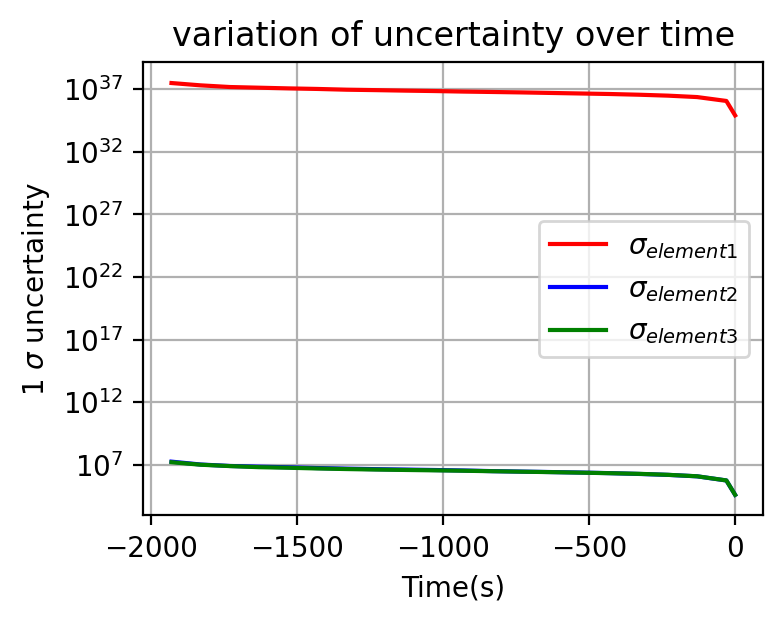

In [68]:
plot.figure(figsize = (4,3), dpi = 200)
plot.plot(info['time_to_coalescence'], errors[:,0], 'r', label = '$\sigma_{element1}$')
plot.plot(info['time_to_coalescence'], errors[:,1], 'b', label = '$\sigma_{element2}$')
plot.plot(info['time_to_coalescence'],errors[:,2], 'g', label = '$\sigma_{element3}$')
plot.xlabel('Time(s)', fontsize = 10)
plot.ylabel('1 $\sigma$ uncertainty', fontsize = 10)
plot.title('variation of uncertainty over time')
plot.grid()
plot.yscale('log')
plot.legend()